In [4]:
from lync.aligner import *

In [3]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

1.12.1+cu116
0.12.1+cu113
cuda


In [4]:
from dataclasses import dataclass
import math
import numpy as np
import IPython
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)

In [5]:
SPEECH_FILE = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

In [6]:
print(SPEECH_FILE)
waveform, _ = torchaudio.load(SPEECH_FILE)
print(waveform.shape)

C:\Users\TheoA\.cache\torch\hub\torchaudio\tutorial-assets\Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav
torch.Size([1, 54400])


In [7]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()

CHUNKS = 6
waveform, srate = torchaudio.load("./cli-test/Nicki Minaj - Anaconda/vocals.wav")
print("srate", srate)
w_len = waveform.shape[1]
chunk_len = int(math.ceil(w_len/CHUNKS))
waveforms = [waveform[0, i:min(w_len,i+chunk_len)].unsqueeze(0) for i in range(CHUNKS)]

srate 44100


In [8]:
emissions_list = []
with torch.inference_mode():
    for i in range(CHUNKS):
        emission, _ = model(waveforms[i].to(device))
        emissions_list.append(torch.log_softmax(emission, dim=-1))

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


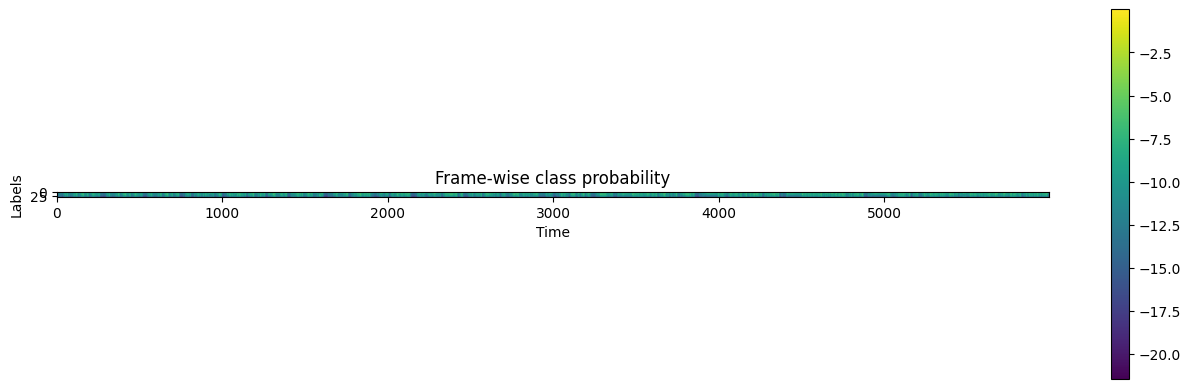

In [32]:
emissions = torch.cat(emissions_list, 0)
print(labels)
emission = emissions[0, :].cpu().detach()
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

In [33]:
LYRICS_PATH = "./cli-test/Nicki Minaj - Anaconda.txt"

lyrics_file = open(LYRICS_PATH, 'r')
transcript  = lyrics_file.read()
transcript_lines = transcript.split("\n")
transcript_cleaned = transcript.strip().replace("\n", " ").upper()
transcript_cleaned = ''.join(filter(lambda chr: chr.isalpha() or chr == " ", transcript_cleaned)).replace(" ", "|")

# testing on the first 3 seconds
#transcript_cleaned = "MY|ANACONDA|DONT|MY|ANACONDA|DONT"
print("transcription:", transcript_cleaned)




dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript_cleaned]
print("tokens:", tokens)
#print(list(zip(transcript_cleaned, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.empty((num_frame + 1, num_tokens + 1))
    trellis[0, 0] = 0
    trellis[1:, 0] = torch.cumsum(emission[:, 0], 0)
    trellis[0, -num_tokens:] = -float("inf")
    trellis[-num_tokens:, 0] = float("inf")

    for t in range(num_frame):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis

# first 3 seconds
trellis = get_trellis(emission, tokens)

transcription: MY|ANACONDA|DONT|MY|ANACONDA|DONT|MY|ANACONDA|DONT|WANT|NONE|UNLESS|YOU|GOT|BUNS|HUN|BOY|TOY|NAMED|TROY|USED|TO|LIVE|IN|DETROIT|BIBIBIG|DOPE|DEALER|MONEY|HE|WAS|GETTIN|SOME|COINS|WAWAWAS|IN|SHOOTOUTS|WITH|THE|LAW|BUT|HE|LIVE|IN|A|PALACE|BOBOUGHT|ME|ALEXANDER|MCQUEEN|HE|WAS|KEEPIN|ME|STYLISH|NOW|THATS|REAL|REAL|REAL|GUN|IN|MY|PURSE|BITCH|I|CAME|DRESSED|TO|KILL|WHOWHOWHOWHO|WANNA|GO|FIRST|I|HAD|EM|PUSHIN|DAFFODILS|IM|HIGH|AS|HELL|I|ONLY|TOOK|A|HALF|A|PILL|IM|ON|SOME|DUMB|SHIT|BYBYBYBYBYBY|THE|WAY|WHAT|HE|SAY|HEY|HEY|HE|CAN|TELL|I|AINT|MISSING|NO|MEALS|HEY|COME|THROUGH|AND|FUCK|HIM|IN|MY|AUTOMOBILE|HEY|LET|HIM|EAT|IT|WITH|HIS|GRILLS|HE|KEEP|TELLIN|ME|TO|CHILL|HE|KEEP|TELLIN|ME|ITS|REAL|THAT|HE|LOVE|MY|SEX|APPEAL|HEY|HE|SAY|HE|DONT|LIKE|EM|BONEY|HE|WANT|SOMETHING|HE|CAN|GRAB|HEY|SO|I|PULLED|UP|IN|THE|JAG|AND|I|HIT|HIM|WITH|THE|JAB|LIKE|HEY|DUNDDDUNDUNDDDUNDUN|HEY|HEY|MY|ANACONDA|DONT|MY|ANACONDA|DONT|MY|ANACONDA|DONT|WANT|NONE|UNLESS|YOU|GOT|BUNS|HUN|OH|MY|GOSH|LOOK|AT|HER|B

In [34]:
print(trellis.shape)
print(filter(lambda x: x!=-float('inf') and x != float('inf'), trellis))

torch.Size([5996, 3118])


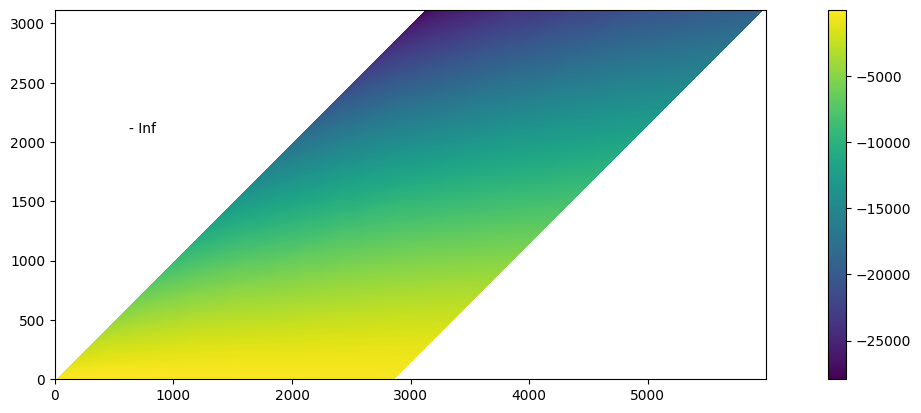

In [35]:
plt.imshow(trellis[1:, 1:].T, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

In [36]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When referring to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when referring to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=4, score=4.627701855497435e-06)
Point(token_index=0, time_index=5, score=0.9995006322860718)
Point(token_index=0, time_index=6, score=0.9995006322860718)
Point(token_index=0, time_index=7, score=0.9995006322860718)
Point(token_index=1, time_index=8, score=1.610603590052051e-06)
Point(token_index=1, time_index=9, score=0.9995005130767822)
Point(token_index=1, time_index=10, score=0.9995006322860718)
Point(token_index=1, time_index=11, score=0.9995005130767822)
Point(token_index=2, time_index=12, score=0.00017144117737188935)
Point(token_index=2, time_index=13, score=0.9995007514953613)
Point(token_index=2, time_index=14, score=0.9995007514953613)
Point(token_index=2, time_index=15, score=0.9995006322860718)
Point(token_index=2, time_index=16, score=0.9995007514953613)
Point(token_index=2, time_index=17, score=0.9995006322860718)
Point(token_index=2, time_index=18, score=0.9995007514953613)
Point(token_index=2, time_index=19, score=0.9995007514953613)
Poin

In [37]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript_cleaned[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

M	(0.75): [    4,     8)
Y	(0.75): [    8,    12)
|	(0.96): [   12,    37)
A	(0.50): [   37,    39)
N	(0.00): [   39,    40)
A	(0.00): [   40,    41)
C	(0.01): [   41,    42)
O	(0.00): [   42,    43)
N	(0.00): [   43,    44)
D	(0.00): [   44,    45)
A	(0.00): [   45,    46)
|	(0.00): [   46,    47)
D	(0.00): [   47,    48)
O	(0.13): [   48,    49)
N	(0.47): [   49,    51)
T	(0.00): [   51,    52)
|	(0.49): [   52,    54)
M	(0.00): [   54,    55)
Y	(0.00): [   55,    56)
|	(0.65): [   56,    59)
A	(0.04): [   59,    60)
N	(0.00): [   60,    61)
A	(0.00): [   61,    62)
C	(0.00): [   62,    63)
O	(0.00): [   63,    64)
N	(0.00): [   64,    65)
D	(0.00): [   65,    66)
A	(0.00): [   66,    67)
|	(0.89): [   67,    76)
D	(0.92): [   76,    99)
O	(0.12): [   99,   100)
N	(0.00): [  100,   101)
T	(0.00): [  101,   102)
|	(0.55): [  102,   104)
M	(0.00): [  104,   105)
Y	(0.00): [  105,   106)
|	(0.01): [  106,   107)
A	(0.00): [  107,   108)
N	(0.66): [  108,   111)
A	(0.00): [  111,   112)


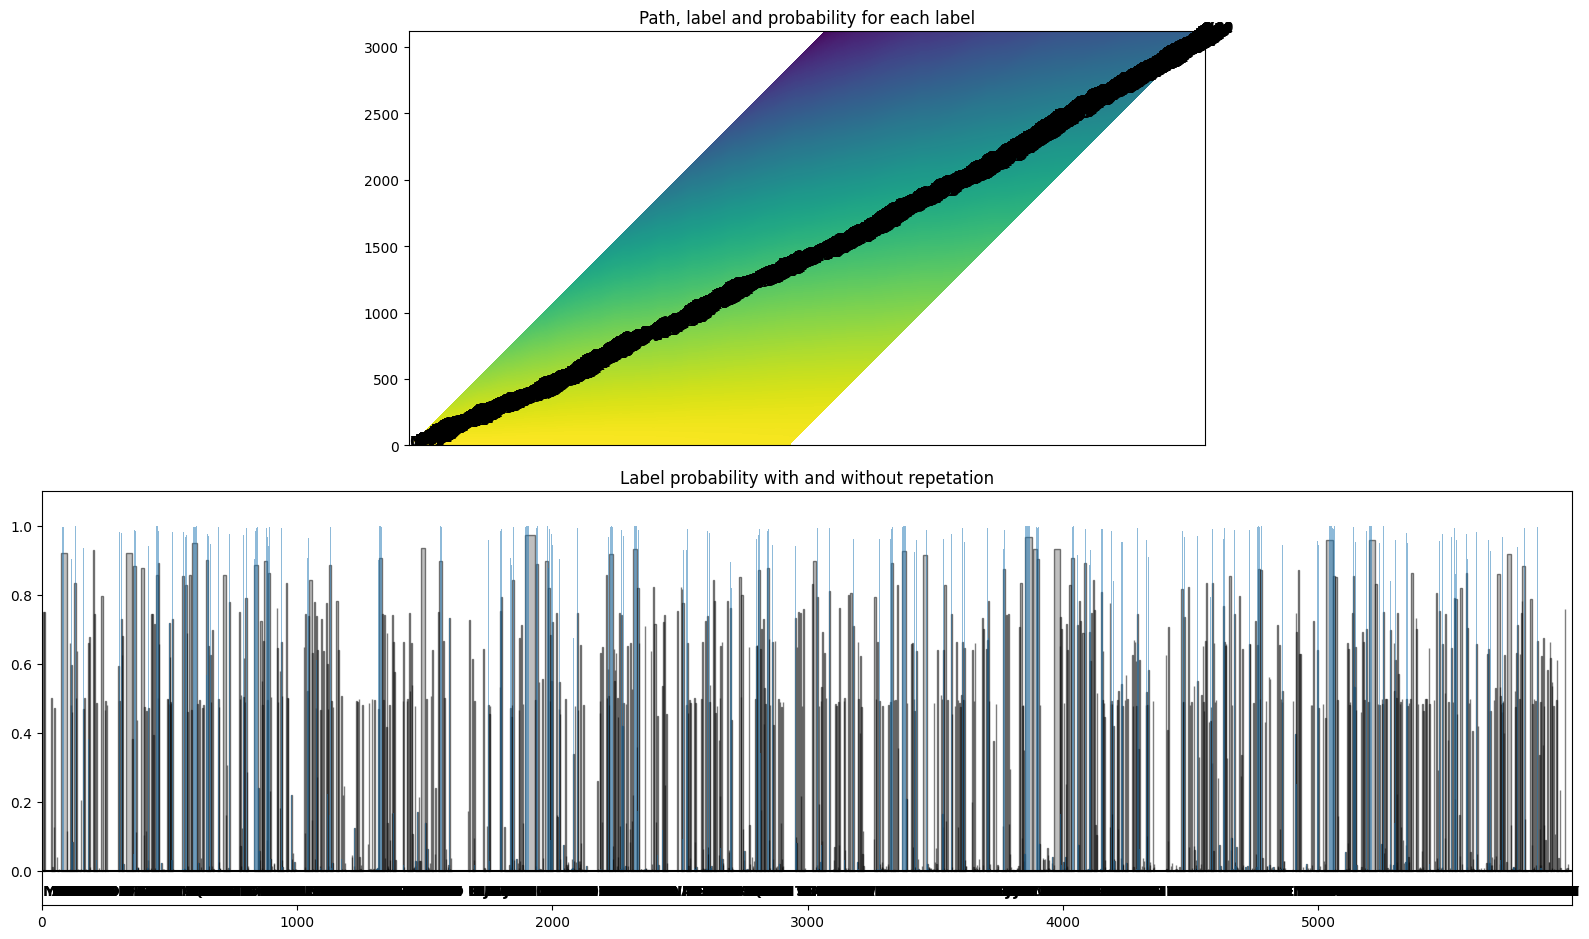

In [38]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower")
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start + 0.7, i + 0.3), weight="bold")
            ax1.annotate(f"{seg.score:.2f}", (seg.start - 0.3, i + 4.3))

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07), weight="bold")
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)


plot_trellis_with_segments(trellis, segments, transcript_cleaned)
plt.tight_layout()
plt.show()

In [39]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

MY	(0.75): [    4,    12)
ANACONDA	(0.11): [   37,    46)
DONT	(0.21): [   47,    52)
MY	(0.00): [   54,    56)
ANACONDA	(0.01): [   59,    67)
DONT	(0.82): [   76,   102)
MY	(0.00): [  104,   106)
ANACONDA	(0.40): [  107,   120)
DONT	(0.00): [  121,   125)
WANT	(0.66): [  127,   138)
NONE	(0.00): [  139,   143)
UNLESS	(0.00): [  144,   150)
YOU	(0.07): [  151,   154)
GOT	(0.00): [  155,   158)
BUNS	(0.19): [  159,   164)
HUN	(0.25): [  165,   169)
BOY	(0.00): [  172,   175)
TOY	(0.00): [  176,   179)
NAMED	(0.45): [  181,   190)
TROY	(0.64): [  201,   210)
USED	(0.19): [  213,   218)
TO	(0.00): [  219,   221)
LIVE	(0.00): [  222,   226)
IN	(0.00): [  227,   229)
DETROIT	(0.36): [  230,   241)
BIBIBIG	(0.21): [  242,   251)
DOPE	(0.19): [  254,   259)
DEALER	(0.31): [  298,   307)
MONEY	(0.58): [  309,   321)
HE	(0.88): [  330,   356)
WAS	(0.74): [  358,   370)
GETTIN	(0.13): [  372,   379)
SOME	(0.70): [  390,   404)
COINS	(0.17): [  405,   411)
WAWAWAS	(0.12): [  412,   420)
IN	(0.00

In [47]:
@dataclass
class TranscriptLine:
    phrase: str
    start_time_s: float
    end_time_s: float

    def __repr__(self):
        return f"{self.phrase}\t({self.start_time_s}, {self.end_time_s})"
    
    @property
    def duration(self):
        return self.end_time_s - self.start_time_s

def merge_lines(word_segs, lyric_lines, waveform_len = w_len, srate = 44100):
    num_frames = word_segs[-1].end

    line_segments = []
    print(lyric_lines[-1])
    transcript_word_idx = 0
    for line in lyric_lines:
        if line == "":
            continue

        line_segment = TranscriptLine(line, word_segs[transcript_word_idx].start / num_frames * waveform_len / srate, -1)
        line_cleaned = line.strip().upper()
        line_cleaned = ''.join(filter(lambda chr: chr.isalpha() or chr == " ", line_cleaned)).split()

        for word in line_cleaned:
            line_segment.end_time_s = word_segs[transcript_word_idx].end / num_frames * waveform_len / srate
            transcript_word_idx+=1
    
        line_segments.append(line_segment)

    return line_segments

merged_lines = merge_lines(word_segments, transcript_lines)

In [48]:
import json
def export_transcript(merged_lines, outfile):
    script = {}
    script['fragments'] = []
    l_id = 0
    for line in merged_lines:
        fragment = {}
        fragment['lines'] = [line.phrase]
        fragment['begin'] = line.start_time_s
        fragment['end'] = line.end_time_s
        fragment['language'] = 'eng'
        fragment['children'] = []
        fragment['id'] = l_id
        l_id+=1
        script['fragments'].append(fragment)
    
    json.dump(script, outfile)

with open("wav2vec2_alignment_anaconda.json", 'w') as f:
    export_transcript(merged_lines, f)
